# Import Dependencies and Data 

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import os 
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model   
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense , Flatten , Reshape , LeakyReLU , Dropout ,UpSampling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import BinaryCrossentropy

In [5]:
import matplotlib.pyplot as plt 
import numpy as np

In [6]:
data = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJN6CLA/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJN6CLA/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
#Setup iterator
data_iterator = data.as_numpy_iterator()

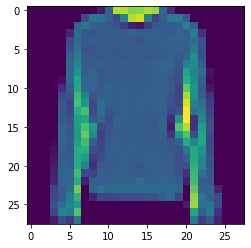

In [8]:
# Grab an image randomly
plt.imshow(np.squeeze(data_iterator.next()['image']))

In [9]:
#Scaling images 
def scale_images(data): 
    image = data['image']
    return image / 255

In [10]:
# Reload the dataset 
data = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
data = data.map(scale_images) 

In [11]:
 # Cache the dataset for that batch 
data = data.cache()
# Shuffle it up 
data = data.shuffle(60000)
# Batch into 128 images per sample
data = data.batch(128)
# Reduces the likelihood of bottlenecking 
data = data.prefetch(64)

In [12]:
def Generator() : 
    model = Sequential()
    
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    return model 

In [13]:
generator = Generator() 

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
img = generator.predict(np.random.randn(2,128,1))

1/1 [==============================] - 8s 8s/step


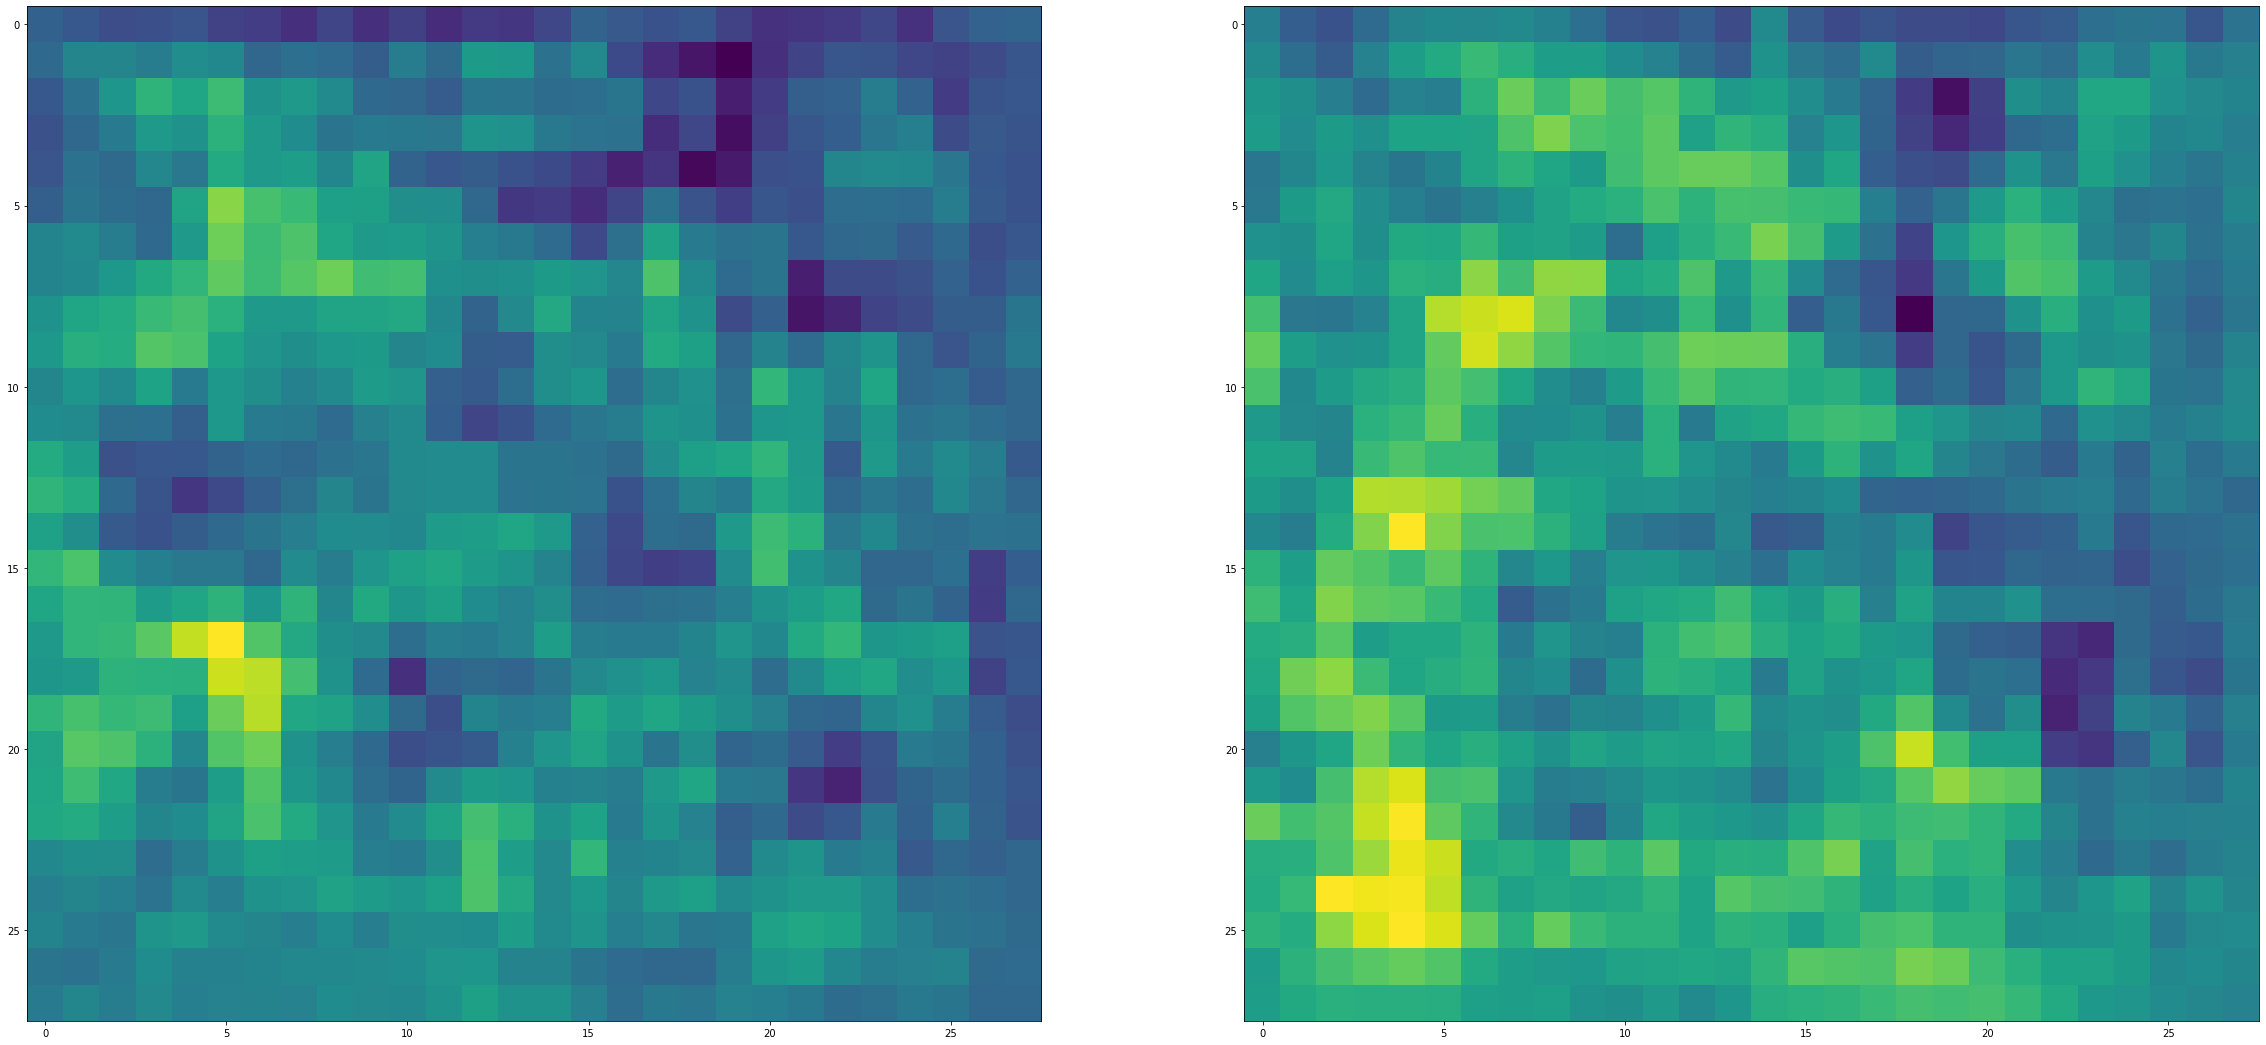

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(40,40))
for idx in range(2):  
    ax[idx].imshow(np.squeeze(img[idx]))

In [17]:
def Discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [18]:
discriminator = Discriminator()

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
discriminator.predict(img)

1/1 [==============================] - 0s 160ms/step


array([[0.5034014 ],
       [0.50343186]], dtype=float32)

In [21]:
generator_opt = Adam(learning_rate=0.0001)
dicriminator_opt = Adam(learning_rate=0.00001)
generator_loss= BinaryCrossentropy()
dicriminator_loss=BinaryCrossentropy()

In [22]:
class GAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [23]:
#create instance of Model
gan = GAN(generator,discriminator)

In [24]:
#compile model 
gan.compile(generator_opt,dicriminator_opt,generator_loss,dicriminator_loss)

In [25]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/Generated_images', f'generated_img_{epoch}_{i}.png'))


In [27]:
Hist = gan.fit(data,epochs=40,callbacks=[ModelMonitor()])

Epoch 1/40
  6/469 [..............................] - ETA: 1:04 - d_loss: 0.6946 - g_loss: 0.6946

469/469 [==============================] - 68s 146ms/step - d_loss: 0.4850 - g_loss: 2.2729
Epoch 2/40
469/469 [==============================] - 73s 156ms/step - d_loss: 0.2891 - g_loss: 5.4732
Epoch 3/40
469/469 [==============================] - 73s 156ms/step - d_loss: 0.2786 - g_loss: 5.7291
Epoch 4/40
469/469 [==============================] - 73s 155ms/step - d_loss: 0.2752 - g_loss: 5.5215
Epoch 5/40
469/469 [==============================] - 73s 156ms/step - d_loss: 0.2736 - g_loss: 5.2655
Epoch 6/40
469/469 [==============================] - 73s 155ms/step - d_loss: 0.2715 - g_loss: 5.0463
Epoch 7/40
469/469 [==============================] - 73s 155ms/step - d_loss: 0.2713 - g_loss: 4.8235
Epoch 8/40
469/469 [==============================] - 73s 155ms/step - d_loss: 0.3290 - g_loss: 3.4953
Epoch 9/40
469/469 [==============================] - 74s 157ms/step - d_loss: 0.4633 - g_loss: 1.6293
Epoch 10/40
469/469 [==============================] - 74s 157ms/step - d_loss: 0.45

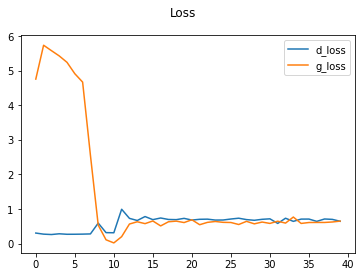

In [28]:
plt.suptitle('Loss')
plt.plot(Hist.history['d_loss'], label='d_loss')
plt.plot(Hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [29]:
generator.save('/content/generator.h5')
discriminator.save('/content/discriminator.h5')

In [43]:
#For better quality of images try to train your model with 2000 epochs or just load weights from generatormodel.h5 